# Different Regularization Experiment

**მიზანი**: ვიპოვო საუკეთესო რეგულარიზაცია 5 Layer CNN-ისთვის.

**გამოყენებული მოდელები**:
- `five_layer_normalization`
- `five_layer_aug`
- `five_layer_dropout`
- `five_layer_norm_drpout`

**მოლოდინი**: five_layer_norm_drpout უნდა მოგვცეს საუკეთესო შედეგი.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/PURI/')
import torch
from my_models import conc_model



Mounted at /content/drive


## 1. იმპორტები

In [2]:
import torch
import torch.nn as nn
import importlib
import sys
from pathlib import Path

from train_models_temp.helper import (
    set_seed,
    get_device,
    print_model_info,
    display_my_result,
)

from train_models_temp.my_trains import(
        EmotionCNNTrainer,
        run_regularization_experiment

)
set_seed(42)
device = get_device()


Seed set to 42
Using GPU: Tesla T4


In [3]:
!pip install wandb
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kechik21 (kechik21-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## 2. მოდელის ბილდინგი

In [4]:
def build_model(model_name, num_classes=7, input_channels=1):
    try:
        from my_models import conc_model
        model = conc_model(curr_model=model_name, num_classes=num_classes)
        return model
    except Exception as e:
        print(f"Error loading {model_name}: {e}")
        raise

print("Model worked")

Model worked


## 3. Data-ს ლოუდინგი

In [5]:
from data.my_data_folder.my_data import get_complete_fer_init, show_plots, plot_class_dist

def load_data(batch_size=64, augment_type='none'):
    print("Loading FER2013  dataset...")
    train_loader, val_loader, test_df = get_complete_fer_init(
        batch_size=batch_size,
        num_workers=2,
        augment_type=augment_type
    )
    print("Data loaded correctly")
    print(f"Train size: {len(train_loader)}")
    print(f"Validation size: {len(val_loader)}")
    return train_loader, val_loader


train_loader, val_loader = load_data(batch_size=64)

Loading FER2013  dataset...
 Using FER2013 from MyDrive
Train : 28709
Validation : 3589
Test : 3589
Data loaded correctly
Train size: 449
Validation size: 57


## 4. თრეინინგის მახასიათებლები

In [6]:
config = {
    'learning_rate': 0.001,
    'num_epochs': 36,
    'patience': 8,
    'device': device,
    'seed': 42,
    'wandb_enabled': True,
    'experiment_name': 'regularization_experiment'
}
print("Training characteristics:")
for k, v in config.items():
    print(f"   {k}: {v}")

Training characteristics:
   learning_rate: 0.001
   num_epochs: 36
   patience: 8
   device: cuda
   seed: 42
   wandb_enabled: True
   experiment_name: regularization_experiment


## 5. მოდელების მახასიათებლების შედარება

In [7]:
curr_mods = [ '5_layer_normalization',
    '5_layer_dropout',
    '5_layer_aug',
    '5_layer_norm_dropout' ]
print(f"Working on {len(curr_mods)} models for Regularization Methods")
print("Testing different reg for different outcomes")
print("")

model_info = {}
prev_params = 0
for i, model_name in enumerate(curr_mods):
    try:
        from my_models import conc_model
        model = conc_model(curr_model=model_name, num_classes=7)
        total_params, trainable_params = print_model_info(model, model_name)


        if i > 0:  #pirveli modeli tu araa
            growth = total_params - prev_params
            growth_ratio = total_params / prev_params
            print(f"Added {growth:,} parameters ({growth_ratio:.1f}x growth from previous)")
        else:
            print("Basic Model")

        model_info[model_name] = {
            'total_params': total_params,
            'trainable_params': trainable_params,
            'layers': 5
        }

        prev_params = total_params
        print()
    except Exception as e:
        print(f"Modeli kvdeba help {model_name}: {e}")
        print("")



Working on 4 models for Regularization Methods
Testing different reg for different outcomes

 5_layer_normalization Info:
   Total parameters: 11,074,247
   Trainable parameters: 11,074,247
Basic Model

 5_layer_dropout Info:
   Total parameters: 11,072,263
   Trainable parameters: 11,072,263
Added -1,984 parameters (1.0x growth from previous)

 5_layer_aug Info:
   Total parameters: 11,072,263
   Trainable parameters: 11,072,263
Added 0 parameters (1.0x growth from previous)

 5_layer_norm_dropout Info:
   Total parameters: 11,074,247
   Trainable parameters: 11,074,247
Added 1,984 parameters (1.0x growth from previous)



## 6. ექსპერიმენტი

In [8]:
trainer = EmotionCNNTrainer(config)
print("")
print("Starting Regularization Exper iment...")
results = run_regularization_experiment(trainer, train_loader, val_loader, build_model)

Trainer ready for cuda

Starting Regularization Exper iment...
Experiment to compare regularization methods

Comparing 4 models...
Training 5_layer_aug...


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


logging epoch 0
  Epoch   0: Train 24.9%, Val 19.4%
logging epoch 3
  Epoch   3: Train 32.8%, Val 25.6%
logging epoch 6
  Epoch   6: Train 42.6%, Val 26.2%
logging epoch 9
  Epoch   9: Train 47.3%, Val 29.7%
logging epoch 12
  Epoch  12: Train 49.5%, Val 27.4%
logging epoch 15
  Epoch  15: Train 51.3%, Val 25.6%
  Early stopping at epoch 17
5_layer_aug: 32.4%


accuracy_gap,▁▂▅▅▇█
best_val_acc_so_far,▁▄▅███
learning_rate,▁▁▁▁▁▁
loss_gap,▁▂▅▆██
train_accuracy,▁▃▆▇██
train_loss,█▆▄▂▂▁
val_accuracy,▁▅▆█▆▅
val_loss,▄▁▄▁█▅
accuracy_gap,25.70541
best_val_acc_so_far,32.43243
learning_rate,0.001


Training 5_layer_normalization...


logging epoch 0
  Epoch   0: Train 40.2%, Val 44.5%
logging epoch 3
  Epoch   3: Train 61.6%, Val 57.9%
logging epoch 6
  Epoch   6: Train 73.1%, Val 59.5%
logging epoch 9
  Epoch   9: Train 87.4%, Val 61.2%
logging epoch 12
  Epoch  12: Train 94.9%, Val 61.5%
logging epoch 15
  Epoch  15: Train 96.6%, Val 61.3%
logging epoch 18
  Epoch  18: Train 97.8%, Val 61.1%
  Early stopping at epoch 20
5_layer_normalization: 62.4%


accuracy_gap,▁▂▄▆▇██
best_val_acc_so_far,▁▆█████
learning_rate,▁▁▁▁▁▁▁
loss_gap,▁▂▂▅▇▇█
train_accuracy,▁▄▅▇███
train_loss,█▆▄▂▁▁▁
val_accuracy,▁▆▇████
val_loss,▃▁▁▃▆▇█
accuracy_gap,36.6395
best_val_acc_so_far,62.38507
learning_rate,0.001


Training 5_layer_dropout...


logging epoch 0
  Epoch   0: Train 24.5%, Val 25.4%
logging epoch 3
  Epoch   3: Train 49.3%, Val 51.5%
logging epoch 6
  Epoch   6: Train 59.2%, Val 56.9%
logging epoch 9
  Epoch   9: Train 68.4%, Val 57.9%
logging epoch 12
  Epoch  12: Train 76.7%, Val 58.2%
logging epoch 15
  Epoch  15: Train 82.9%, Val 57.9%
logging epoch 18
  Epoch  18: Train 87.4%, Val 59.2%
logging epoch 21
  Epoch  21: Train 90.2%, Val 57.8%
logging epoch 24
  Epoch  24: Train 91.4%, Val 57.8%
  Early stopping at epoch 26
5_layer_dropout: 59.3%


accuracy_gap,▁▁▂▃▅▆▇██
best_val_acc_so_far,▁▆███████
learning_rate,▁▁▁▁▁▁▁▁▁
loss_gap,▁▁▁▂▄▅▇██
train_accuracy,▁▄▅▆▆▇███
train_loss,█▆▅▄▃▂▁▁▁
val_accuracy,▁▆███████
val_loss,▇▂▁▁▃▄▆██
accuracy_gap,33.5983
best_val_acc_so_far,59.26442
learning_rate,0.001


Training 5_layer_norm_dropout...


logging epoch 0
  Epoch   0: Train 32.9%, Val 42.7%
logging epoch 3
  Epoch   3: Train 51.4%, Val 52.9%
logging epoch 6
  Epoch   6: Train 58.6%, Val 55.2%
logging epoch 9
  Epoch   9: Train 64.8%, Val 58.6%
logging epoch 12
  Epoch  12: Train 71.3%, Val 60.5%
logging epoch 15
  Epoch  15: Train 77.9%, Val 61.4%
logging epoch 18
  Epoch  18: Train 83.1%, Val 60.7%
logging epoch 21
  Epoch  21: Train 86.3%, Val 60.2%
  Early stopping at epoch 24
5_layer_norm_dropout: 61.4%


accuracy_gap,▁▃▄▄▅▆▇█
best_val_acc_so_far,▁▅▆▇████
learning_rate,▁▁▁▁▁▁▁▁
loss_gap,▁▂▃▄▄▆▇█
train_accuracy,▁▃▄▅▆▇██
train_loss,█▆▅▄▃▂▁▁
val_accuracy,▁▅▆▇████
val_loss,█▄▃▂▁▂▃▄
accuracy_gap,26.1932
best_val_acc_so_far,61.40986
learning_rate,0.001



Final outcome
1. 5 Layer Normalization
   Accuracy: 62.4%
   Params: 11,074,247
   Status: Overfitting

2. 5 Layer Norm Dropout
   Accuracy: 61.4%
   Params: 11,074,247
   Status: Overfitting

3. 5 Layer Dropout
   Accuracy: 59.3%
   Params: 11,072,263
   Status: Overfitting

4. 5 Layer Aug
   Accuracy: 32.4%
   Params: 11,072,263
   Status: Underfitting

Better model is: 5 Layer Normalization (62.4%)

Full Predictions
X 5 Layer Aug:
   Predicted: Less overfitting than basic 5-layer due to data augmentation regularization
   Reality:   ძალიან ცუდი მოდელია

X 5 Layer Normalization:
   Predicted: More stable and faster convergence than basic 5-layer
   Reality:   Training accurac მაღალია და სხვაობაც საკმაოდ დიდია

X 5 Layer Dropout:
   Predicted: Much less overfitting than basic 5-layer, but may train slower
   Reality:   Training accurac მაღალია და სხვაობაც საკმაოდ დიდია

X 5 Layer Norm Dropout:
   Predicted: Most balanced model - stable training with minimal overfitting
   Reality:   

## 7. მნინშვნელოვანი საბოლოო პარამეტრები და მათი დალოგვა

In [15]:
import matplotlib.pyplot as plt
import importlib
import train_models_temp.plotting
importlib.reload(train_models_temp.plotting)

from train_models_temp.plotting import (
    plot_training_curves,
    plot_validation_comparison,
    plot_parameter_effectiveness,
    plot_training_curves,
    plot_model_comparison
)



In [16]:
# Initialize wandb for summary metrics
wandb.init(project="regularization_experiment",
           name="experiment2_results_summary",
           tags=["summary", "regularization", "experiment2"])

trainer_results = trainer.results
all_metrics = {}  # Collect all metrics to log at once

for model_name, result in trainer_results.items():
    overfitting_score = max(0, (result['final_train_acc'] - result['best_val_acc']) / 10)

    chem_metr = {
        "final_train_accuracy": result['final_train_acc'],
        "final_val_accuracy": result['best_val_acc'],
        "final_overfitting_score": overfitting_score,
        "total_parameters": result['parameters'],
        "training_time_minutes": result['training_time'] / 60,
        "epochs_trained": len(result['val_accs']),
        "best_epoch": result['val_accs'].index(max(result['val_accs'])) + 1,
        "model_name": model_name,
        "fit_status": result['actual_results']['fit_status'],
        "performance": result['actual_results']['performance'],
        "efficiency_status": result['actual_results']['efficiency_status'],
        "prediction": result['prediction']['prediction'],
        "reality": result['actual_results']['fit_analysis'],
        "prediction_correct": result['prediction_correct']
    }

    print(" ")
    print(f" {model_name.replace('_', ' ').title()} Results ")
    for key, value in chem_metr.items():
        if key != "model_name":
            print(f"{key.replace('_', ' ').title()}: {value}")

    for key, value in chem_metr.items():
        if key != "model_name":
            wandb_key = f"final_results/{model_name}/{key}"
            all_metrics[wandb_key] = value

wandb.log(all_metrics)

print(" Results processed and logged to wandb")
wandb.finish()

 
 5 Layer Aug Results 
Final Train Accuracy: 51.50649622069734
Final Val Accuracy: 32.432432432432435
Final Overfitting Score: 1.9074063788264908
Total Parameters: 11072263
Training Time Minutes: 8.552134907245636
Epochs Trained: 17
Best Epoch: 9
Fit Status: Underfitting
Performance: Bad performance
Efficiency Status: Slow training speed
Prediction: Less overfitting than basic 5-layer due to data augmentation regularization
Reality: ძალიან ცუდი მოდელია
Prediction Correct: False
 
 5 Layer Normalization Results 
Final Train Accuracy: 97.59657250339615
Final Val Accuracy: 62.38506547784898
Final Overfitting Score: 3.521150702554716
Total Parameters: 11074247
Training Time Minutes: 5.278025694688162
Epochs Trained: 20
Best Epoch: 12
Fit Status: Overfitting
Performance: Normal performance
Efficiency Status: Good training speed
Prediction: More stable and faster convergence than basic 5-layer
Reality: Training accurac მაღალია და სხვაობაც საკმაოდ დიდია
Prediction Correct: False
 
 5 Layer D

final_results/5_layer_aug/best_epoch,▁
final_results/5_layer_aug/epochs_trained,▁
final_results/5_layer_aug/final_overfitting_score,▁
final_results/5_layer_aug/final_train_accuracy,▁
final_results/5_layer_aug/final_val_accuracy,▁
final_results/5_layer_aug/total_parameters,▁
final_results/5_layer_aug/training_time_minutes,▁
final_results/5_layer_dropout/best_epoch,▁
final_results/5_layer_dropout/epochs_trained,▁
final_results/5_layer_dropout/final_overfitting_score,▁
final_results/5_layer_dropout/final_train_accuracy,▁


## 8. შედეგების ვიზუალიზაცია და დალოგვა

In [17]:
from train_models_temp.plotting import (
    plot_model_comparison,
    plot_metrics_over_epochs,
    plot_parameter_effectiveness
)



Working on Stage 2 plots


<Figure size 1200x800 with 0 Axes>

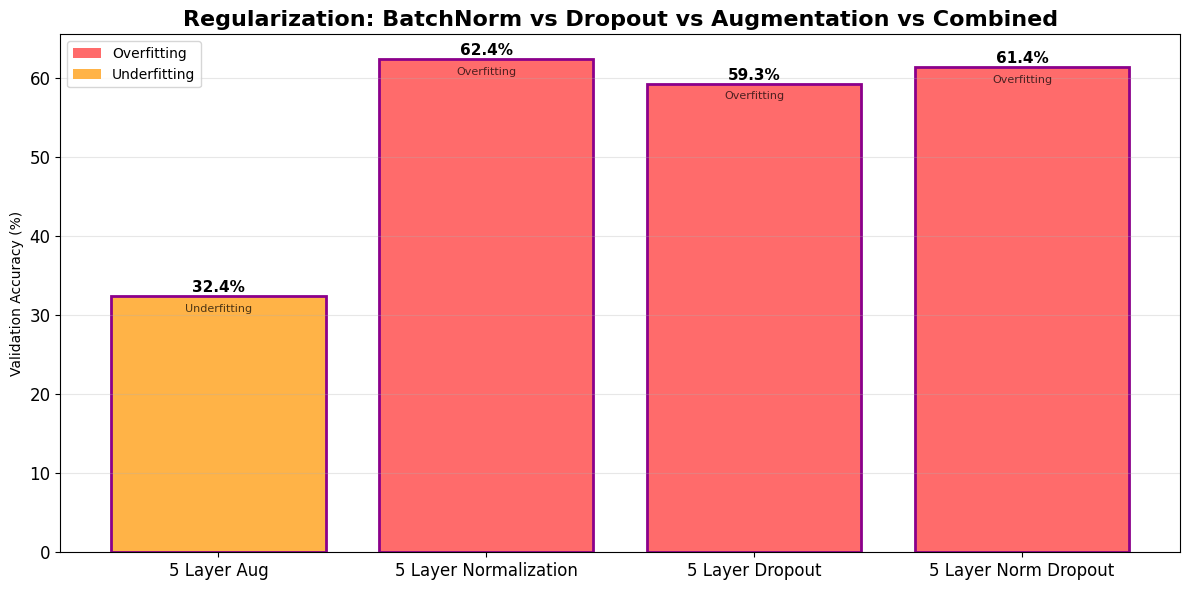

<Figure size 1500x1000 with 0 Axes>

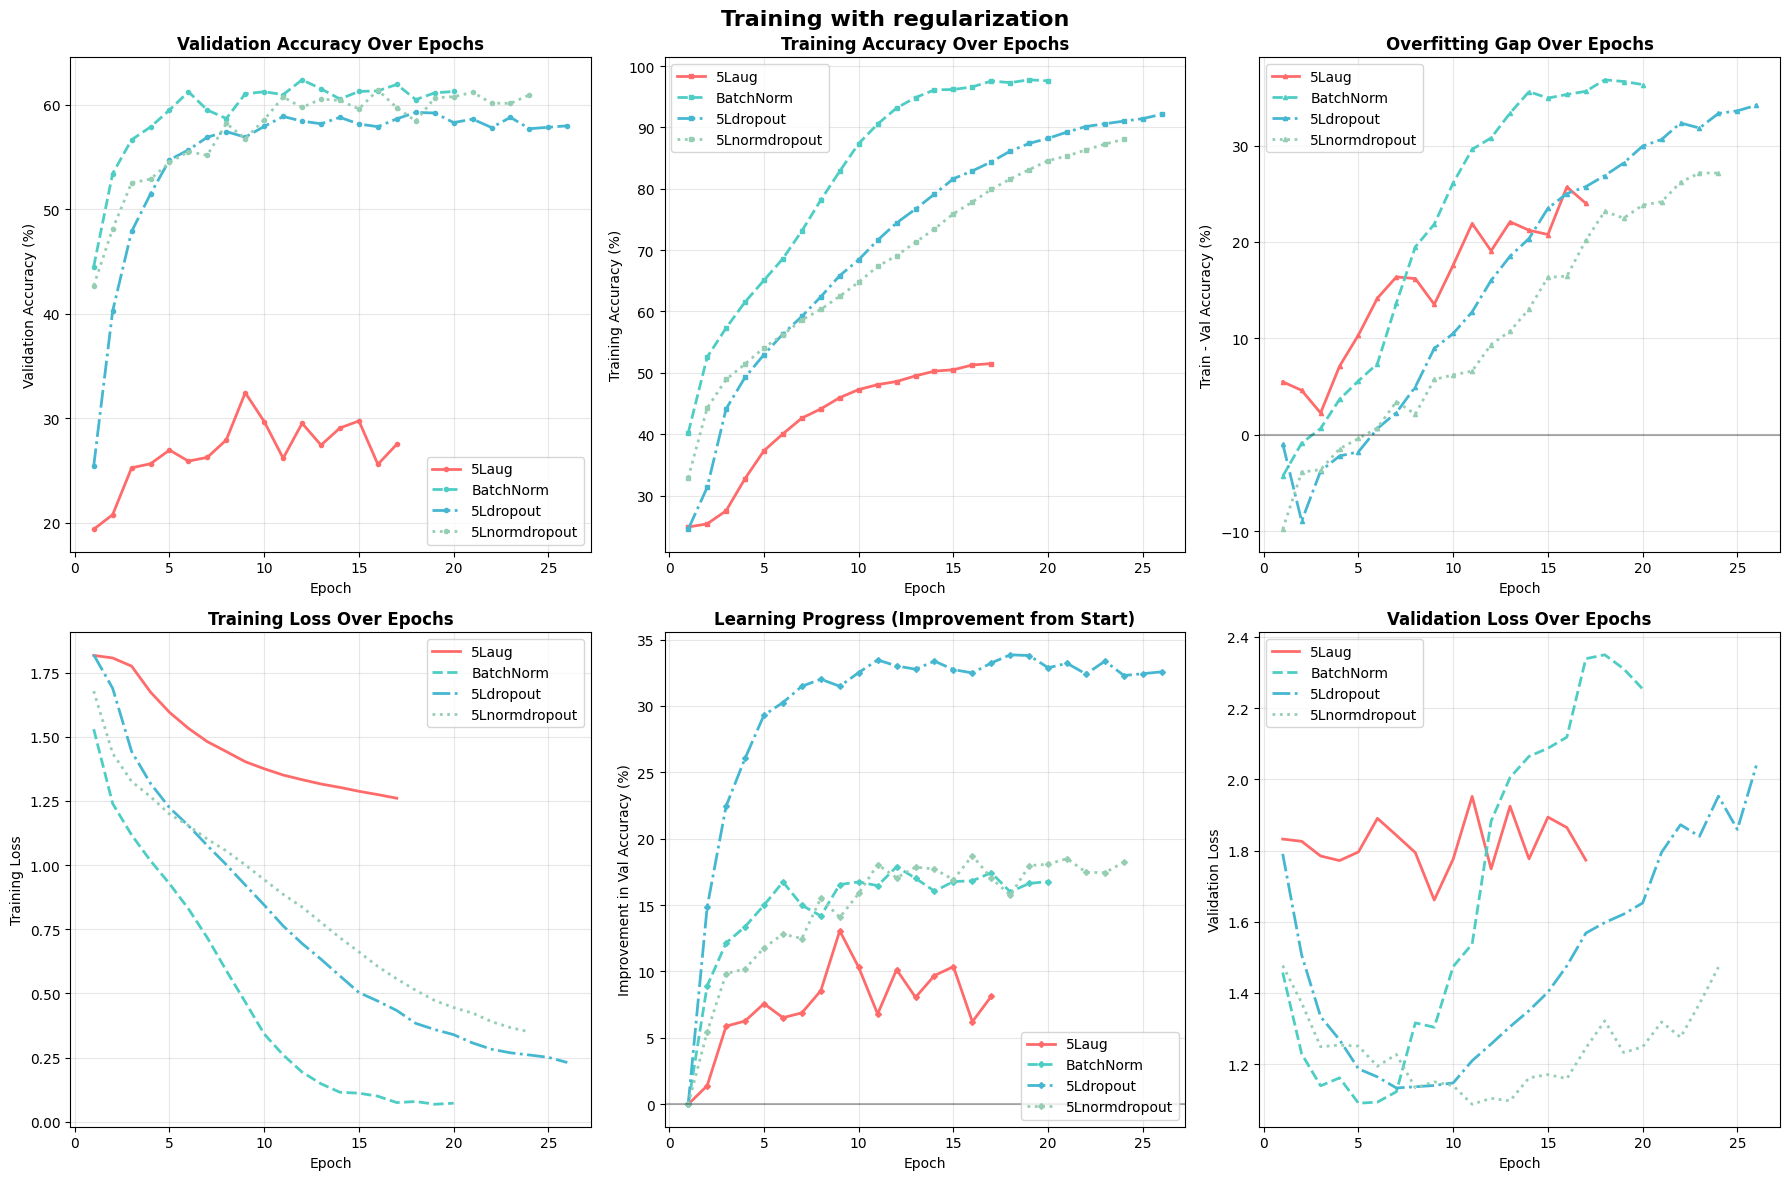

<Figure size 1000x800 with 0 Axes>

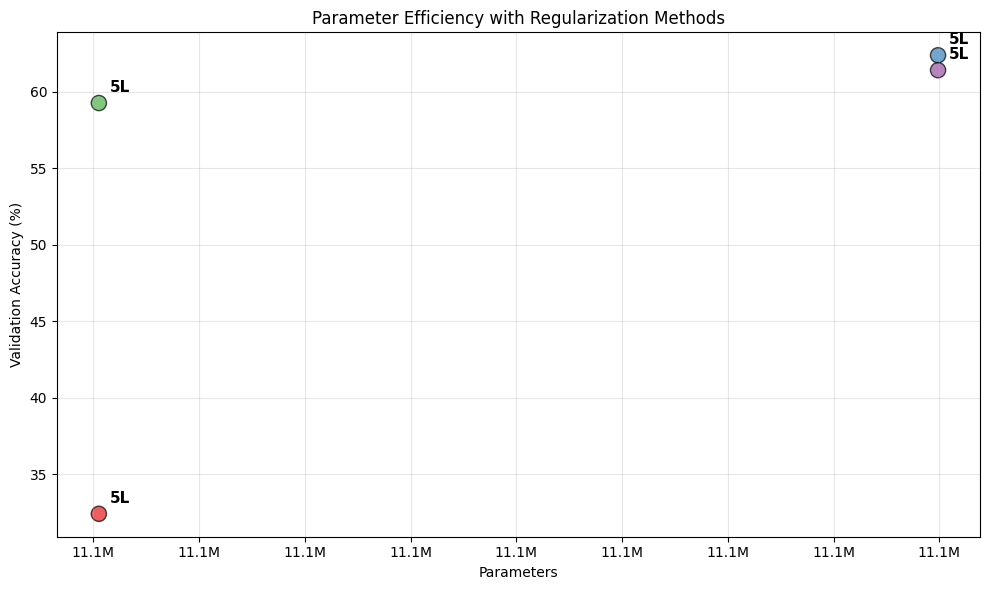

In [27]:
print("Working on Stage 2 plots")

wandb.init(project="regularization_exp",
           name="regularization_summary",
           tags=["summary", "regularization", "stage2"],
           notes="Comparing regularization methods")

# Plot 1: Model Comparison
plt.figure(figsize=(12, 8))
plot_model_comparison(trainer_results, "Regularization: BatchNorm vs Dropout vs Augmentation vs Combined")
wandb.log({"reg_comparison_bars": wandb.Image(plt.gcf())})  # This will now capture the plot!
plt.close()

# Plot 2: Training Dynamics
plt.figure(figsize=(15, 10))
plot_metrics_over_epochs(trainer_results, "Training with regularization")
wandb.log({"training_dynamics_analysis": wandb.Image(plt.gcf())})  # This will work too!
plt.close()

# Plot 3: Parameter Effectiveness
plt.figure(figsize=(10, 8))
plot_parameter_effectiveness(trainer_results, "Parameter Efficiency with Regularization Methods")
wandb.log({"parameter_effectiveness_scatter": wandb.Image(plt.gcf())})  # Perfect!
plt.close()

In [28]:
print("Plotting done ")

Plotting done 


## 9. ჩემი დასკვნა და საბოლოო ანალიზი

In [29]:
normalization_result = None
dropout_result = None
augm_result = None
norm_dropout_result = None

for model_name, result in trainer_results.items():
    if model_name == '5_layer_normalization':  # Changed: Use correct model names
        normalization_result = {
            'best_val_acc': result['best_val_acc'],
            'final_train_acc': result['final_train_acc'],
            'total_params': result['parameters']
        }
    elif model_name == '5_layer_dropout':
        dropout_result = {
            'best_val_acc': result['best_val_acc'],
            'final_train_acc': result['final_train_acc'],
            'total_params': result['parameters']
        }
    elif model_name == '5_layer_aug':
        augm_result = {
            'best_val_acc': result['best_val_acc'],
            'final_train_acc': result['final_train_acc'],
            'total_params': result['parameters']
        }
    elif model_name == '5_layer_norm_dropout':
        norm_dropout_result = {
            'best_val_acc': result['best_val_acc'],
            'final_train_acc': result['final_train_acc'],
            'total_params': result['parameters']
        }

all_results = {
    'BatchNorm': normalization_result,
    'Dropout': dropout_result,
    'Augmentation': augm_result,
    'BatchNorm+Dropout': norm_dropout_result
}

valid_results = {k: v for k, v in all_results.items() if v is not None}

if valid_results:
    best_regularization = max(valid_results.items(), key=lambda x: x[1]['best_val_acc'])
    print("The best regularization method is:")
    print(f"{best_regularization[0]}: {best_regularization[1]['best_val_acc']:.1f}% validation accuracy")

    print("\nAll successful results:")
    for name, result in valid_results.items():
        print(f"{name}: {result['best_val_acc']:.1f}% val acc, {result['total_params']:,} params")
else:
    print("No models trained successfully")

print(f"\nAvailable models in trainer_results: {list(trainer_results.keys())}")

The best regularization method is:
BatchNorm: 62.4% validation accuracy

All successful results:
BatchNorm: 62.4% val acc, 11,074,247 params
Dropout: 59.3% val acc, 11,072,263 params
Augmentation: 32.4% val acc, 11,072,263 params
BatchNorm+Dropout: 61.4% val acc, 11,074,247 params

Available models in trainer_results: ['5_layer_aug', '5_layer_normalization', '5_layer_dropout', '5_layer_norm_dropout']
